### Font

In [47]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

# Read Dataset

In [10]:
import pandas as pd
from pathlib import Path

# -----------------------------
# 설정
# -----------------------------
MOTION_FILES = [
    "../datasets/090_Tm_7.5_HS_3.5.out",
    "../datasets/090_Tm_9.5_HS_3.5.out",
    "../datasets/090_Tm_11.5_HS_3.5.out",
    "../datasets/135_Tm_7.5_HS_3.5.out",
    "../datasets/135_Tm_9.5_HS_3.5.out",
    "../datasets/135_Tm_11.5_HS_3.5.out",
    "../datasets/180_Tm_7.5_HS_3.5.out",
    "../datasets/180_Tm_9.5_HS_3.5.out",
    "../datasets/180_Tm_11.5_HS_3.5.out"
]

WAVE_FILES = [
    "../datasets/Wave_090_Tm_7.5_HS_3.5.out",
    "../datasets/Wave_090_Tm_9.5_HS_3.5.out",
    "../datasets/Wave_090_Tm_11.5_HS_3.5.out",
    "../datasets/Wave_135_Tm_7.5_HS_3.5.out",
    "../datasets/Wave_135_Tm_9.5_HS_3.5.out",
    "../datasets/Wave_135_Tm_11.5_HS_3.5.out",
    "../datasets/Wave_180_Tm_7.5_HS_3.5.out",
    "../datasets/Wave_180_Tm_9.5_HS_3.5.out",
    "../datasets/Wave_180_Tm_11.5_HS_3.5.out"
]

MOTION_COLUMNS = ["t(s)", "x1(m)", "x2(m)", "x3(m)", "x4(deg)", "x5(deg)", "x6(deg)"]
WAVE_COLUMNS = ["t(s)", "z(m)"]

# -----------------------------
# 함수 정의
# -----------------------------

def read_motion_files(file_list):
    dataframes = []
    for idx, file in enumerate(file_list, start=1):
        df = pd.read_csv(file, sep=r'\s+', skiprows=1, header=None)
        df.columns = MOTION_COLUMNS
        df["file_index"] = idx
        dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

def read_wave_files(file_list):
    dataframes = []
    for idx, file in enumerate(file_list, start=1):
        df = pd.read_csv(file, sep=r'\s+', skiprows=1, header=None)
        df.columns = WAVE_COLUMNS
        df["file_index"] = idx
        dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

def count_file_rows(file_list):
    print("=== 파일별 row 개수 ===")
    for file in file_list:
        count = pd.read_csv(file, sep=r'\s+', skiprows=1).shape[0]  # 수정됨
        print(f"{file}: {count} rows")

def align_file_index(motion_df, wave_df):
    # 같은 순서로 정렬 후 file_index 재할당 (0부터 시작)
    motion_df["file_index"] = motion_df.groupby("file_index").ngroup()
    wave_df["file_index"] = wave_df.groupby("file_index").ngroup()
    return motion_df, wave_df

# -----------------------------
# 실행
# -----------------------------

# 1. 파일별 row 개수 확인: 99999 rows
# count_file_rows(MOTION_FILES + WAVE_FILES)

# 2. 데이터 로드
combined_df = read_motion_files(MOTION_FILES)
df_wave_combined = read_wave_files(WAVE_FILES)

# 3. file_index 재정렬
combined_df, df_wave_combined = align_file_index(combined_df, df_wave_combined)

# 4. 병합
df_merged = pd.merge(combined_df, df_wave_combined, on=["t(s)", "file_index"], how="inner")

# 5. 결과 확인
print("\n=== 병합된 데이터 샘플 ===")
# print(df_merged.head())
print(df_merged.info())

# 6. file_index 개수 확인
print(f"\nMotion file_index 개수: {combined_df['file_index'].nunique()}")
print(f"Wave file_index 개수:   {df_wave_combined['file_index'].nunique()}")



=== 병합된 데이터 샘플 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   t(s)        900000 non-null  float64
 1   x1(m)       900000 non-null  float64
 2   x2(m)       900000 non-null  float64
 3   x3(m)       900000 non-null  float64
 4   x4(deg)     900000 non-null  float64
 5   x5(deg)     900000 non-null  float64
 6   x6(deg)     900000 non-null  float64
 7   file_index  900000 non-null  int64  
 8   z(m)        900000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 61.8 MB
None

Motion file_index 개수: 9
Wave file_index 개수:   9


In [11]:
from sklearn.preprocessing import StandardScaler

def normalize_all(df):
    feature_columns = [col for col in df.columns if col not in ["t(s)", "file_index"]]

    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(df[feature_columns])

    normalized_df = df.copy()
    normalized_df[feature_columns] = scaled_values

    return normalized_df, scaler  # ✅ scaler도 함께 반환

df_merged, scaler = normalize_all(df_merged)  # 이 scaler를 계속 저장해서 쓰기

In [12]:
def sequential_split_by_file_index(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    train_list, val_list, test_list = [], [], []

    for file_idx, group_df in df.groupby("file_index"):
        group_df = group_df.sort_values("t(s)").reset_index(drop=True)
        n = len(group_df)

        # 비율에 맞게 자르고, 각 부분을 100 단위로 버림
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)

        n_train = n_train // 100 * 100
        n_val = n_val // 100 * 100
        n_test = (n - n_train - n_val) // 100 * 100

        # 슬라이싱할 인덱스
        train_end = n_train
        val_end = train_end + n_val
        test_end = val_end + n_test  # 이 범위 이후는 버림

        train_list.append(group_df.iloc[:train_end])
        val_list.append(group_df.iloc[train_end:val_end])
        test_list.append(group_df.iloc[val_end:test_end])

    train_df = pd.concat(train_list).reset_index(drop=True)
    val_df = pd.concat(val_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)

    return train_df, val_df, test_df

# 적용
train_df, val_df, test_df = sequential_split_by_file_index(df_merged)

# 확인
print(f"\n[Train] {len(train_df)} rows, file_index: {sorted(train_df['file_index'].unique())}")
print(f"[Val]   {len(val_df)} rows, file_index: {sorted(val_df['file_index'].unique())}")
print(f"[Test]  {len(test_df)} rows, file_index: {sorted(test_df['file_index'].unique())}")



[Train] 630000 rows, file_index: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
[Val]   135000 rows, file_index: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
[Test]  135000 rows, file_index: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]


## 모델 불러오기

In [13]:
import torch.nn as nn

# ----------------------------
# 모델 정의
# ----------------------------
class RNNModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

class GRUModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out)
        return out

class BiLSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=1):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers,
            batch_first=True, bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

## 예측값 저장

In [ ]:
import os
import torch
import pandas as pd
import numpy as np

# 설정
pred_len = 200
sample_intervals = [1, 2, 5, 10]
input_columns = ["x1(m)", "x2(m)", "x3(m)", "x4(deg)", "x5(deg)", "x6(deg)"]
base_model_dir = "model/model_tests/6DoF_6DoF"
model_classes = {
    "rnn": RNNModel,
    "lstm": LSTMModel,
    "gru": GRUModel,
    "bi-lstm": BiLSTMModel,
}

# 결과 저장소
all_groundtruth = {}
all_prediction = {n: {name: [] for name in model_classes} for n in sample_intervals}

# 모델 로딩
models = {}
for n in sample_intervals:
    for name, cls in model_classes.items():
        model_prefix = f"{name.upper()}_seq{pred_len}_n{n}"
        model_dir = os.path.join(base_model_dir, "layer2", "node64")
        ckpt_path = os.path.join(model_dir, f"{model_prefix}.ckpt")

        if os.path.exists(ckpt_path):
            state = torch.load(ckpt_path, map_location="cpu")
            state_dict = state["state_dict"]
            state_dict = {k.replace("model.", ""): v for k, v in state_dict.items()}

            model = cls(input_dim=6, hidden_dim=64, num_layers=2, output_dim=6)
            model.load_state_dict(state_dict)
            model.eval()

            models[(name, n)] = model
            print(f"✅ 모델 로드 완료: {ckpt_path}")
        else:
            print(f"❌ 모델 파일 없음: {ckpt_path}")

# 예측 수행
for n in sample_intervals:
    print(f"\n🔍 예측 시작: n={n}")

    # 데이터 로드 및 file_index==4 필터링
    csv_path = f"dataset/Downsampling{n}/test_n{n}.csv"
    test_df = pd.read_csv(csv_path)
    test_df = test_df[test_df["file_index"] == 4].reset_index(drop=True)
    df_heave = test_df["x3(m)"].values.astype(np.float32)

    input_seq_len = pred_len // n
    output_seq_len = pred_len // n
    total_len = input_seq_len + output_seq_len

    groundtruth = []
    prediction = {name: [] for name in model_classes}

    for start in range(0, len(df_heave) - total_len + 1, output_seq_len):
        input_seq = test_df.iloc[start : start + input_seq_len][input_columns].values.astype(np.float32)
        output_seq = df_heave[start + input_seq_len : start + total_len]

        input_tensor = torch.tensor(input_seq).unsqueeze(0)
        output_tensor = torch.tensor(output_seq).unsqueeze(0).unsqueeze(2)

        groundtruth.extend(output_tensor.squeeze().numpy())

        for name in model_classes:
            model = models.get((name, n))
            if model:
                with torch.no_grad():
                    pred = model(input_tensor).squeeze().numpy()
                prediction[name].extend(pred[:, 2])  # x3(m) column

    all_groundtruth[n] = groundtruth
    all_prediction[n] = prediction
    print(f"✅ 예측 완료: n={n}, 샘플 수: {len(groundtruth)}")


- 예측값 저장

In [ ]:
import pandas as pd
import os

# -----------------------------------
# Configuration
# -----------------------------------
CSV_PATH = "../peak_dataset/6DoF26DoF/seq200_downsampling_predictions.csv"

# -----------------------------------
# Collect predictions into a flat list of records
# Assumes: all_prediction[n][model_name] = list of predictions
# -----------------------------------
rows = []

for n in sample_intervals:
    for model_name in model_classes:
        preds = all_prediction[n][model_name]
        print(f"📊 {model_name} (n={n}) number of predictions: {len(preds)}")

        for t, pred in enumerate(preds):
            rows.append({
                "prediction": pred,
                "model": model_name,
                "n": n,
                "timestep": 1 + pred_len + t * n  # Adjusted timestep based on stride
            })

# -----------------------------------
# Save as CSV
# -----------------------------------
df_predictions = pd.DataFrame(rows)
os.makedirs(os.path.dirname(CSV_PATH), exist_ok=True)
df_predictions.to_csv(CSV_PATH, index=False)

print(f"✅ Saved all_prediction results to → {CSV_PATH}")


📊 rnn (n=1) 예측 수: 14800
📊 lstm (n=1) 예측 수: 14800
📊 gru (n=1) 예측 수: 14800
📊 bi-lstm (n=1) 예측 수: 14800
📊 rnn (n=2) 예측 수: 7400
📊 lstm (n=2) 예측 수: 7400
📊 gru (n=2) 예측 수: 7400
📊 bi-lstm (n=2) 예측 수: 7400
📊 rnn (n=5) 예측 수: 2960
📊 lstm (n=5) 예측 수: 2960
📊 gru (n=5) 예측 수: 2960
📊 bi-lstm (n=5) 예측 수: 2960
📊 rnn (n=10) 예측 수: 1480
📊 lstm (n=10) 예측 수: 1480
📊 gru (n=10) 예측 수: 1480
📊 bi-lstm (n=10) 예측 수: 1480
✅ all_prediction 결과 저장 완료 → dataset/6DoF26DoF/seq200_downsampling_predictions.csv


- 예측값 정렬

In [15]:
import pandas as pd

# CSV 불러오기
csv_path = "../peak_dataset/6DoF26DoF/seq200_downsampling_predictions.csv"
df = pd.read_csv(csv_path)

# (model, n) 기준으로 그룹핑 및 정렬 # timestep 포함 정렬 추가
df_sorted = df.sort_values(by=["model", "n", "timestep"]).reset_index(drop=True)

# 결과 저장 (선택사항)
df_sorted.to_csv("../peak_dataset/6DoF26DoF/seq200_downsampling_predictions_sorted.csv", index=False)

# 예측 개수 집계
grouped = df_sorted.groupby(["model", "n"])["prediction"].count().reset_index(name="count")

print("📊 각 (model, n) 조합별 예측 개수:")
for _, row in grouped.iterrows():
    print(f"  - {row['model']} (n={row['n']}): 예측 개수 = {row['count']}")


📊 각 (model, n) 조합별 예측 개수:
  - bi-lstm (n=1): 예측 개수 = 14800
  - bi-lstm (n=2): 예측 개수 = 7400
  - bi-lstm (n=5): 예측 개수 = 2960
  - bi-lstm (n=10): 예측 개수 = 1480
  - gru (n=1): 예측 개수 = 14800
  - gru (n=2): 예측 개수 = 7400
  - gru (n=5): 예측 개수 = 2960
  - gru (n=10): 예측 개수 = 1480
  - lstm (n=1): 예측 개수 = 14800
  - lstm (n=2): 예측 개수 = 7400
  - lstm (n=5): 예측 개수 = 2960
  - lstm (n=10): 예측 개수 = 1480
  - rnn (n=1): 예측 개수 = 14800
  - rnn (n=2): 예측 개수 = 7400
  - rnn (n=5): 예측 개수 = 2960
  - rnn (n=10): 예측 개수 = 1480


- 성능 비교

In [27]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import pandas as pd

# # 데이터 및 설정
# df = pd.read_csv("dataset/6DoF26DoF/seq200_downsampling_predictions_sorted.csv")
# x_start = 1000
# x_end = 47701

# print("📊 Prediction Error Summary (MSE & MAE)")
# print("=" * 60)

# records = []

# # 모델 리스트 및 sample intervals
# models = list(df["model"].unique())
# sample_intervals = sorted(df["n"].unique())
# pred_lens = sorted(df["pred_len"].unique())

# # 각 모델, n, pred_len 조합별 에러 측정
# for model in models:
#     for n in sample_intervals:
#         for pred_len in pred_lens:
#             subset = df[(df["model"] == model) & (df["n"] == n) & (df["pred_len"] == pred_len)]
#             x_pred = subset["timestep"].values
#             y_pred = subset["prediction"].values

#             # x 범위 필터링
#             mask = (x_pred >= x_start) & (x_pred <= x_end)
#             x_valid = x_pred[mask]
#             y_valid = y_pred[mask]

#             # Ground Truth와 정확히 매칭
#             gt_segment = df_heave[x_valid]

#             if len(gt_segment) != len(y_valid) or len(y_valid) == 0:
#                 continue

#             mse = mean_squared_error(gt_segment, y_valid)
#             mae = mean_absolute_error(gt_segment, y_valid)

#             records.append({
#                 "model": model.upper(),
#                 "n": n,
#                 "pred_len": pred_len,
#                 "MSE": mse,
#                 "MAE": mae
#             })

# # 결과 출력 및 저장
# df_result = pd.DataFrame(records)
# df_result = df_result.sort_values(by=["pred_len", "model", "n"])
# df_result[["MSE", "MAE"]] = df_result[["MSE", "MAE"]].round(5)

# print(df_result.to_string(index=False))

# csv_output_path = "dataset/downsampled_result/evaluation_summary.csv"
# df_result.to_csv(csv_output_path, index=False)
# print(f"\n✅ Evaluation results saved to: {csv_output_path}")


- 예측 출력

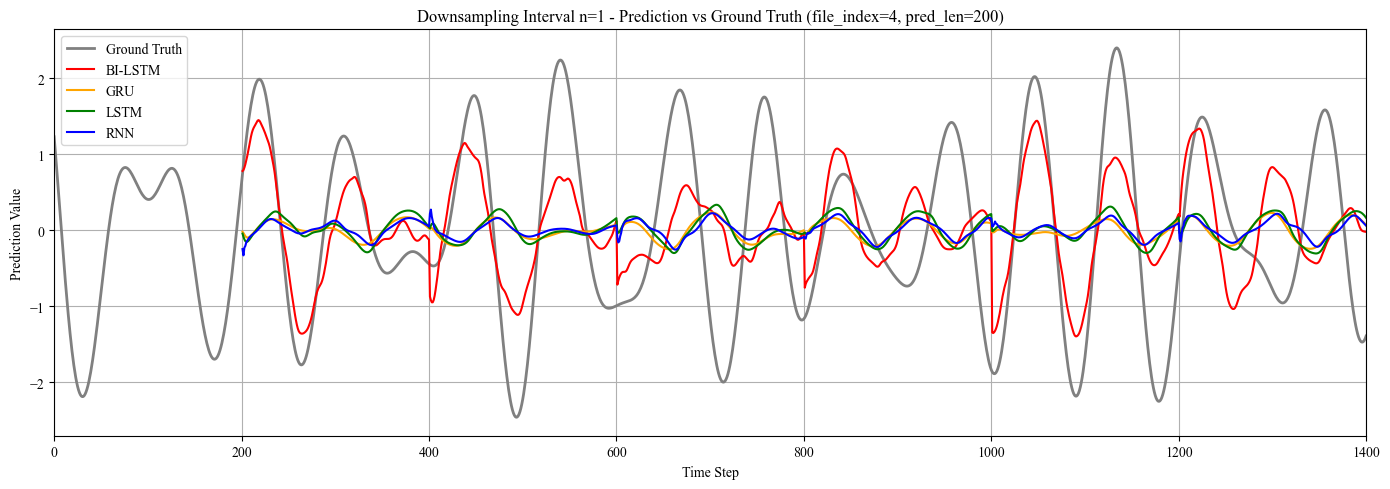

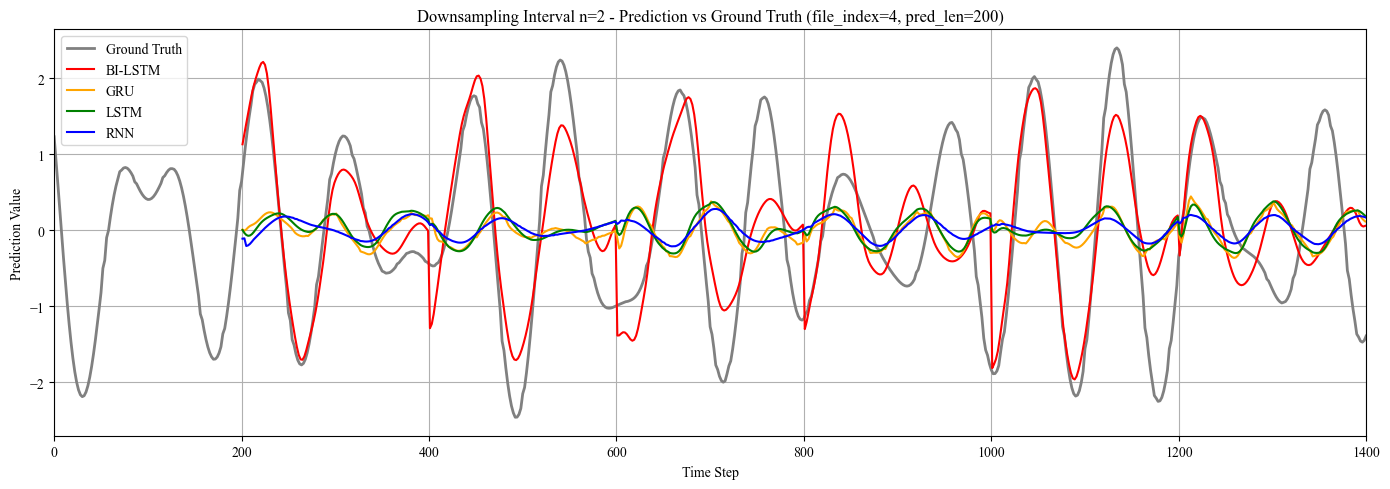

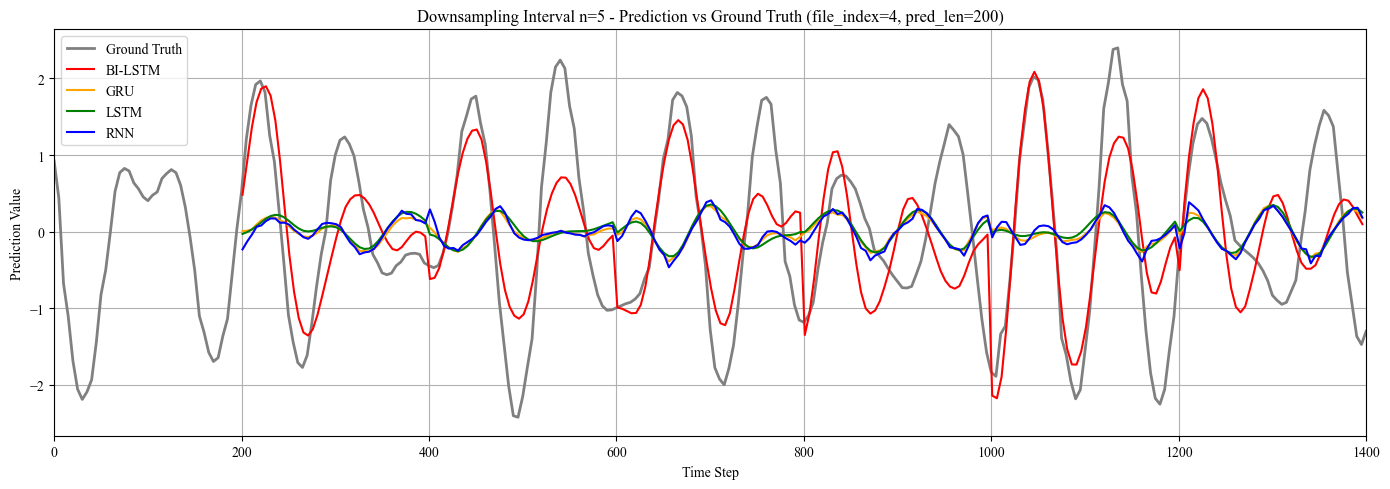

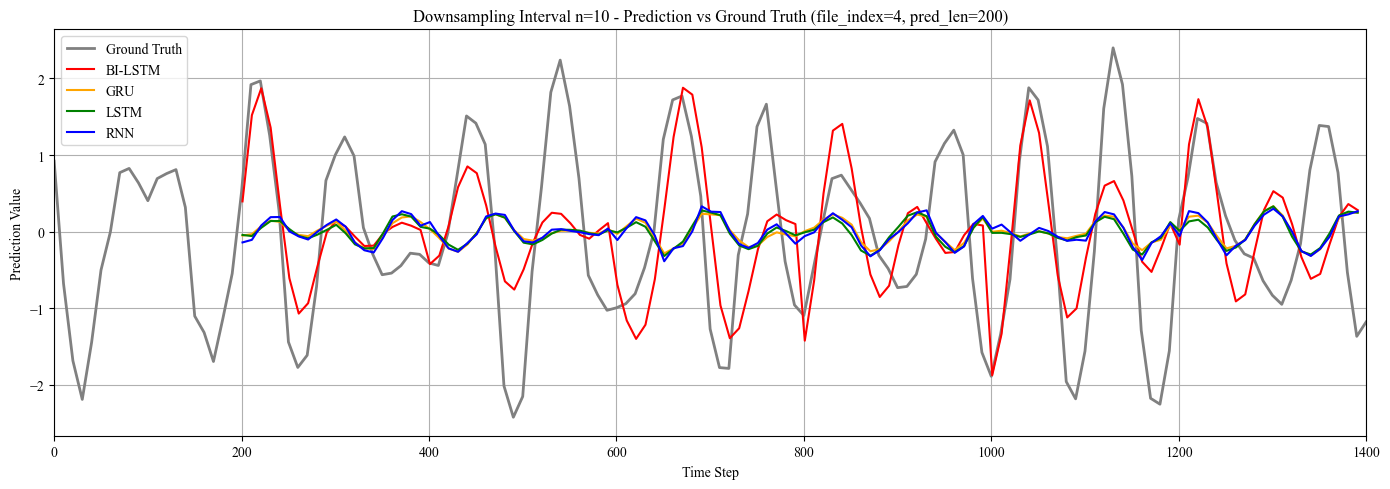

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------
# Configuration
# -----------------------------------
CSV_PREDICTION_PATH = "../peak_dataset/6DoF26DoF/seq200_downsampling_predictions_sorted.csv"
GT_PATH_TEMPLATE = "../downsampled_data/Downsampling{}/test_n{}.csv"

X_START = 0
X_END = 1400
SELECTED_PRED_LEN = 200

# -----------------------------------
# Load prediction results
# -----------------------------------
df = pd.read_csv(CSV_PREDICTION_PATH)
df["pred_len"] = SELECTED_PRED_LEN  # Manually assign prediction length
df = df[df["pred_len"] == SELECTED_PRED_LEN]

# -----------------------------------
# Load ground truth for each sampling interval
# -----------------------------------
groundtruth_by_n = {}
for n in df["n"].unique():
    gt_df = pd.read_csv(GT_PATH_TEMPLATE.format(int(n), int(n)))
    gt_df = gt_df[gt_df["file_index"] == 4].reset_index(drop=True)
    groundtruth_by_n[n] = gt_df["x3(m)"].values.astype(np.float32)

# -----------------------------------
# Define model-specific colors
# -----------------------------------
model_colors = {
    "bi-lstm": "red",
    "gru": "orange",
    "lstm": "green",
    "rnn": "blue"
}

# -----------------------------------
# Plot predictions vs ground truth by sampling interval
# -----------------------------------
sample_intervals = sorted(df["n"].unique())
models = df["model"].unique()

for n in sample_intervals:
    plt.figure(figsize=(14, 5))
    plt.title(f"Downsampling Interval n={n} - Prediction vs Ground Truth (file_index=4, pred_len={SELECTED_PRED_LEN})")
    plt.xlabel("Time Step")
    plt.ylabel("Prediction Value")

    # Plot ground truth
    gt_heave = groundtruth_by_n[n]
    x_gt = np.arange(len(gt_heave)) * n  # Reflect sampling interval
    mask_gt = (x_gt >= X_START) & (x_gt <= X_END)
    plt.plot(x_gt[mask_gt], gt_heave[mask_gt], label="Ground Truth", color="gray", linewidth=2)

    # Plot predictions for each model
    for model in models:
        subset = df[(df["n"] == n) & (df["model"] == model)]
        x_pred = subset["timestep"].values
        y_pred = subset["prediction"].values

        mask_pred = (x_pred >= X_START) & (x_pred <= X_END)
        if len(x_pred[mask_pred]) == 0:
            continue

        plt.plot(
            x_pred[mask_pred],
            y_pred[mask_pred],
            label=model.upper(),
            color=model_colors.get(model, "black"),
            linestyle='-'
        )

    plt.xlim(X_START, X_END)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Peak Matching Function

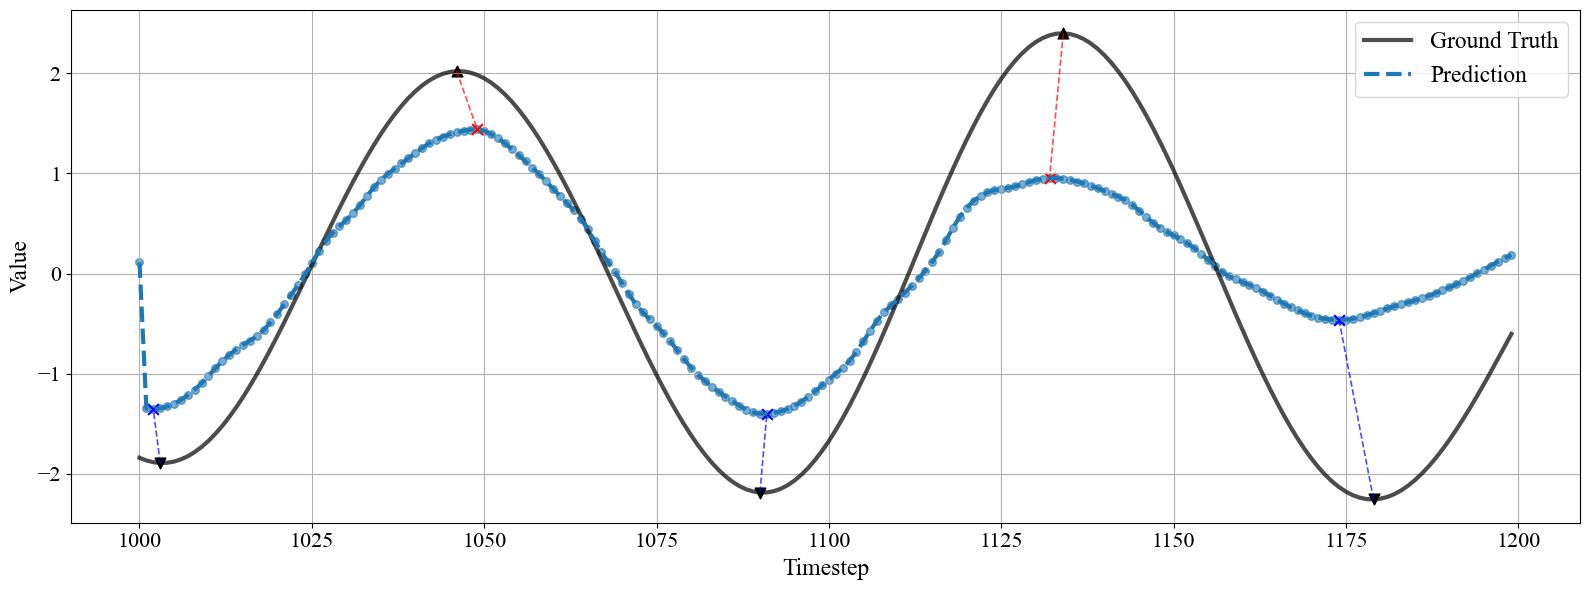

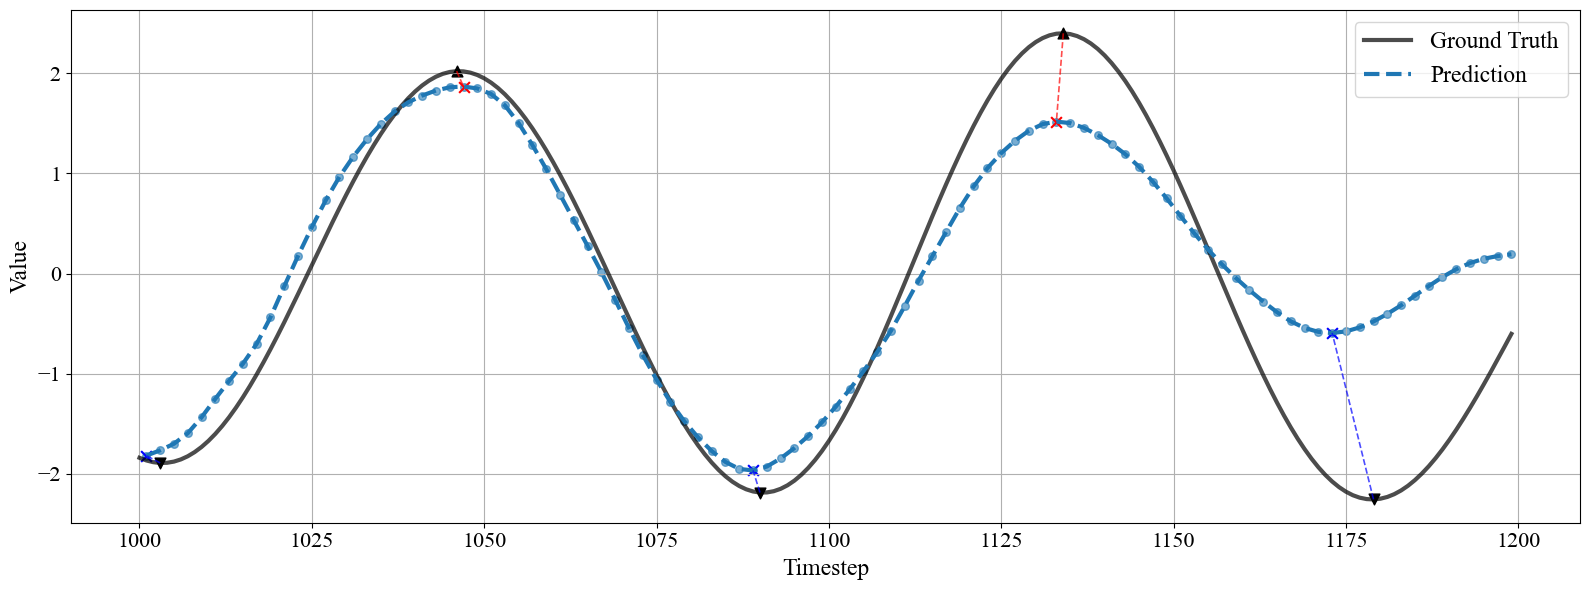

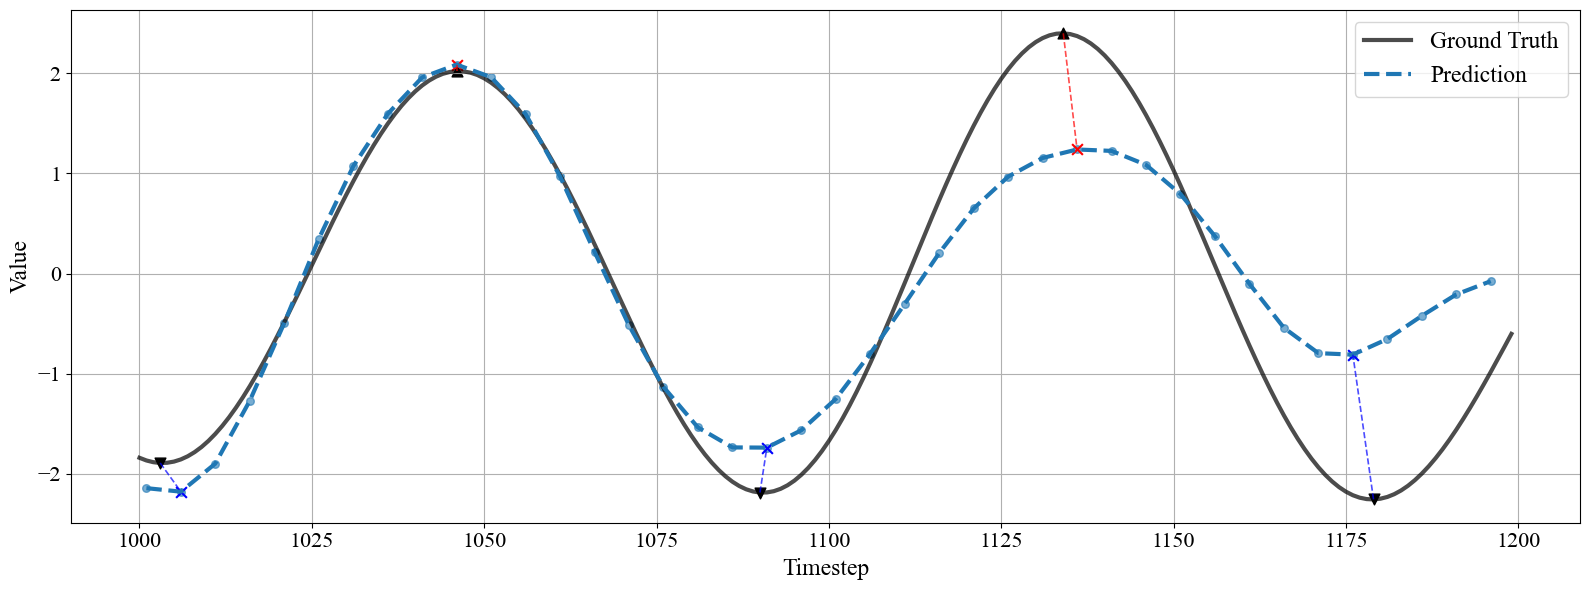

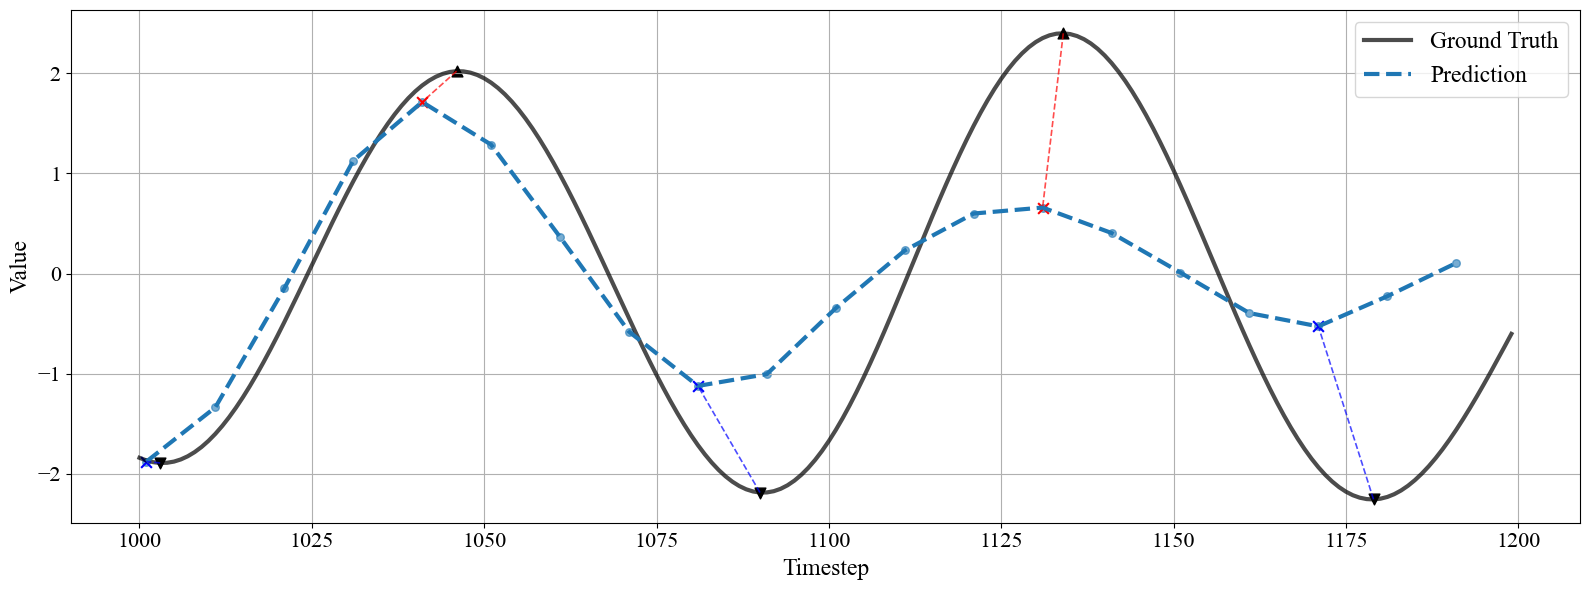

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# -----------------------------------
# Configuration
# -----------------------------------
CSV_PRED_PATH = "../peak_dataset/6DoF26DoF/seq200_downsampling_predictions_sorted.csv"
CSV_GT_PATH = "../downsampled_data/Downsampling1/test_n1.csv"

SELECTED_PRED_LEN = 200
X_START = 1000
X_END = 1200
MIN_MATCH_GAP = 55  # Constraint 3: minimum gap between matches

# -----------------------------------
# Load prediction results (BI-LSTM only)
# -----------------------------------
df = pd.read_csv(CSV_PRED_PATH)
df = df[df["model"].str.lower() == "bi-lstm"]

sample_intervals = sorted(df["n"].unique())
models = df["model"].unique()

prediction_by_n = {n: {} for n in sample_intervals}
timestep_by_n = {n: {} for n in sample_intervals}

for model in models:
    for n in sample_intervals:
        subset = df[(df["model"] == model) & (df["n"] == n)]
        prediction_by_n[n][model.upper()] = subset["prediction"].values
        timestep_by_n[n][model.upper()] = subset["timestep"].values

# -----------------------------------
# Load ground truth (n=1 only)
# -----------------------------------
gt_df = pd.read_csv(CSV_GT_PATH)
gt_df = gt_df[gt_df["file_index"] == 4].reset_index(drop=True)
gt_signal = gt_df["x3(m)"].values.astype(np.float32)
gt_x = np.arange(len(gt_signal))

# Detect peaks and troughs (Constraint 1)
peak_indices, _ = find_peaks(gt_signal, distance=30)
trough_indices, _ = find_peaks(-gt_signal, distance=30)

# -----------------------------------
# Matching function with constraints
# Constraint 2: match within range
# Constraint 3: avoid duplicate matches (min gap)
# Extreme strategy: choose max (peak) or min (trough)
# -----------------------------------
def match_and_draw_extreme(gt_idxs, gt_vals, pred_vals, pred_x, start, end,
                           is_peak=True, color="red", marker_gt="^", marker_pred="x"):
    matched_gt = []
    matched_pred = []

    for gt_idx in gt_idxs:
        if not (start <= gt_idx < end):
            continue

        # Constraint 3: skip if too close to previous matched GT
        if any(abs(gt_idx - prev) < MIN_MATCH_GAP for prev in matched_gt):
            continue

        # Constraint 2: find candidate preds not already matched
        valid_pred_indices = [i for i, px in enumerate(pred_x)
                              if abs(px - gt_idx) <= MIN_MATCH_GAP and
                              all(abs(px - p) >= MIN_MATCH_GAP for p in matched_pred)]

        if not valid_pred_indices:
            continue

        # Select extreme value: max for peak, min for trough
        if is_peak:
            best_i = max(valid_pred_indices, key=lambda i: pred_vals[i])
        else:
            best_i = min(valid_pred_indices, key=lambda i: pred_vals[i])

        best_pred_x = pred_x[best_i]
        best_pred_y = pred_vals[best_i]
        gt_y = gt_vals[gt_idx]

        matched_gt.append(gt_idx)
        matched_pred.append(best_pred_x)

        # Visualization
        plt.plot([gt_idx, best_pred_x], [gt_y, best_pred_y],
                 linestyle="--", color=color, linewidth=1.2, alpha=0.7)
        plt.scatter(gt_idx, gt_y, color="black", marker=marker_gt, s=60)
        plt.scatter(best_pred_x, best_pred_y, color=color, marker=marker_pred, s=60)

# -----------------------------------
# Visualization loop per sampling interval
# -----------------------------------
for n in sample_intervals:
    plt.figure(figsize=(16, 6))
    start, end = X_START, X_END

    # Plot ground truth
    mask_gt = (gt_x >= start) & (gt_x < end)
    plt.plot(gt_x[mask_gt], gt_signal[mask_gt], label="Ground Truth",
             color="black", linewidth=3, alpha=0.7)

    for model_name in prediction_by_n[n]:
        pred = prediction_by_n[n][model_name]
        timestep_pred = timestep_by_n[n][model_name]

        # Filter prediction window
        mask = (timestep_pred >= start) & (timestep_pred < end)
        pred = pred[mask]
        timestep_pred = timestep_pred[mask]

        if len(pred) == 0:
            continue

        # Plot prediction
        plt.plot(timestep_pred, pred, label="Prediction",
                 linewidth=3, linestyle='--')
        plt.scatter(timestep_pred, pred, s=30, alpha=0.6)

        # Match and plot peaks
        match_and_draw_extreme(peak_indices, gt_signal, pred, timestep_pred,
                               start, end, is_peak=True,
                               color="red", marker_gt="^", marker_pred="x")

        # Match and plot troughs
        match_and_draw_extreme(trough_indices, gt_signal, pred, timestep_pred,
                               start, end, is_peak=False,
                               color="blue", marker_gt="v", marker_pred="x")

    fontsize = 17
    plt.xlabel("Timestep", fontsize=fontsize)
    plt.ylabel("Value", fontsize=fontsize)
    plt.xticks(fontsize=fontsize - 1)
    plt.yticks(fontsize=fontsize - 1)
    plt.legend(fontsize=fontsize)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Save Peak Points

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import os

# -----------------------------
# Base paths for data loading/saving
# -----------------------------
downsample_base_path = "../downsampled_data"
prediction_base_path = "../peak_dataset"

# -----------------------------
# Configuration
# -----------------------------
selected_pred_len = 200
desired_range_dist = 50
desired_peak_dist = 50
desired_min_pred_gap = 55

# -----------------------------
# 1. Load Ground Truth data (fixed at n=1)
# -----------------------------
gt_csv_path = os.path.join(downsample_base_path, "Downsampling1/test_n1.csv")
gt_df = pd.read_csv(gt_csv_path)
gt_df = gt_df[gt_df["file_index"] == 4].reset_index(drop=True)
gt_signal = gt_df["x3(m)"].values.astype(np.float32)
x_gt = np.arange(len(gt_signal))  # full range

# -----------------------------
# 2. Load prediction results (BI-LSTM only)
# -----------------------------
pred_csv_path = os.path.join(prediction_base_path, "6DoF26DoF/seq200_downsampling_predictions_sorted.csv")
df = pd.read_csv(pred_csv_path)
df = df[df["model"].str.lower() == "bi-lstm"]

sample_intervals = sorted(df["n"].unique())
model_names = df["model"].unique()

prediction_by_n = {n: {} for n in sample_intervals}
timestep_by_n = {n: {} for n in sample_intervals}

for model in model_names:
    for n in sample_intervals:
        subset = df[(df["model"] == model) & (df["n"] == n)]
        prediction_by_n[n][model.upper()] = subset["prediction"].values
        timestep_by_n[n][model.upper()] = subset["timestep"].values

# -----------------------------
# 3. Define matching logic
# -----------------------------
matched_peaks = []
peak_count_by_n = {n: {"peak": 0, "trough": 0} for n in sample_intervals}

def match_and_record(gt_idxs, pred_vals, pred_x, gt_vals, range_dist, min_pred_gap, is_peak, model_name, n):
    matched = set()
    last_pred_x = -np.inf

    for gt_idx in gt_idxs:
        search_start = gt_idx - range_dist
        search_end = gt_idx + range_dist

        candidates = [
            i for i in range(len(pred_x))
            if search_start <= pred_x[i] <= search_end
            and i not in matched
            and abs(pred_x[i] - last_pred_x) >= min_pred_gap
        ]

        if not candidates:
            continue

        filtered_candidates = []
        for i in candidates:
            if i + 1 >= len(pred_vals):
                filtered_candidates.append(i)
                continue

            current_val = pred_vals[i]
            next_val = pred_vals[i + 1]

            if is_peak and next_val <= current_val:
                filtered_candidates.append(i)
            elif not is_peak and next_val >= current_val:
                filtered_candidates.append(i)

        if not filtered_candidates:
            continue

        best_idx = max(filtered_candidates, key=lambda i: pred_vals[i]) if is_peak else min(filtered_candidates, key=lambda i: pred_vals[i])
        matched.add(best_idx)

        matched_peaks.append({
            "model": model_name,
            "n": n,
            "pred_len": selected_pred_len,
            "is_peak": is_peak,
            "gt_timestep": gt_idx,
            "gt_value": gt_vals[gt_idx],
            "pred_timestep": pred_x[best_idx],
            "pred_value": pred_vals[best_idx],
        })

        if is_peak:
            peak_count_by_n[n]["peak"] += 1
        else:
            peak_count_by_n[n]["trough"] += 1

# -----------------------------
# 4. Perform GT-to-prediction peak matching
# -----------------------------
for n in sample_intervals:
    range_dist = desired_range_dist // n
    peak_dist = max(1, desired_peak_dist // n)
    min_pred_gap = desired_min_pred_gap // n

    gt_peaks, _ = find_peaks(gt_signal, distance=peak_dist)
    gt_troughs, _ = find_peaks(-gt_signal, distance=peak_dist)
    gt_peaks = x_gt[gt_peaks]
    gt_troughs = x_gt[gt_troughs]

    for model_name in prediction_by_n[n]:
        pred = prediction_by_n[n][model_name]
        timestep_pred = timestep_by_n[n][model_name]

        # Match peaks
        match_and_record(
            gt_peaks, pred, timestep_pred, gt_signal,
            range_dist, min_pred_gap, is_peak=True,
            model_name=model_name, n=n
        )

        # Match troughs
        match_and_record(
            gt_troughs, pred, timestep_pred, gt_signal,
            range_dist, min_pred_gap, is_peak=False,
            model_name=model_name, n=n
        )

# -----------------------------
# 5. Save results and print summary
# -----------------------------
output_csv = os.path.join(prediction_base_path, f"6DoF26DoF/matched_peak_points_bilstm_predlen{selected_pred_len}.csv")
os.makedirs(os.path.dirname(output_csv), exist_ok=True)
pd.DataFrame(matched_peaks).to_csv(output_csv, index=False)

print(f"\n✅ Matching results saved → {output_csv}")
print("📊 Peak/trough matches by n:")
for n in sample_intervals:
    peak_cnt = peak_count_by_n[n]["peak"]
    trough_cnt = peak_count_by_n[n]["trough"]
    print(f"  n={n}: Peak={peak_cnt}, Trough={trough_cnt}, Total={peak_cnt + trough_cnt}")


In [24]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks

# -----------------------------------
# Configuration
# -----------------------------------
SELECTED_PRED_LEN = 200
DESIRED_RANGE_DIST = 50
CSV_GT_PATH = "../downsampled_data/Downsampling1/test_n1.csv"
CSV_PREDICTION_PATH = "../peak_dataset/6DoF26DoF/seq200_downsampling_predictions_sorted.csv"
CSV_OUTPUT_PATH = f"../peak_dataset/6DoF26DoF/matched_peak_points_bilstm_predlen{SELECTED_PRED_LEN}.csv"

# -----------------------------------
# 1. Load Ground Truth (fixed n=1)
# -----------------------------------
gt_df = pd.read_csv(CSV_GT_PATH)
gt_df = gt_df[gt_df["file_index"] == 4].reset_index(drop=True)
gt_signal = gt_df["x3(m)"].values.astype(np.float32)
x_gt = np.arange(len(gt_signal))

# -----------------------------------
# 2. Load prediction results (BI-LSTM only)
# -----------------------------------
df = pd.read_csv(CSV_PREDICTION_PATH)
df = df[df["model"].str.lower() == "bi-lstm"]

sample_intervals = sorted(df["n"].unique())
model_names = df["model"].unique()

# Organize predictions by (n, model)
prediction_by_n = {n: {} for n in sample_intervals}
timestep_by_n = {n: {} for n in sample_intervals}

for model in model_names:
    for n in sample_intervals:
        subset = df[(df["model"] == model) & (df["n"] == n)]
        prediction_by_n[n][model.upper()] = subset["prediction"].values
        timestep_by_n[n][model.upper()] = subset["timestep"].values

# -----------------------------------
# 3. Matching function (fixed GT locations)
# -----------------------------------
matched_peaks = []

def match_gt_fixed(gt_idxs, gt_vals, pred_vals, pred_x, model_name, n, is_peak):
    for gt_idx in gt_idxs:
        if len(pred_x) == 0:
            continue

        closest_idx = np.argmin(np.abs(pred_x - gt_idx))
        closest_dist = abs(pred_x[closest_idx] - gt_idx)

        if closest_dist > (DESIRED_RANGE_DIST // n):
            # No valid match within range
            matched_peaks.append({
                "model": model_name,
                "n": n,
                "pred_len": SELECTED_PRED_LEN,
                "is_peak": is_peak,
                "gt_timestep": gt_idx,
                "gt_value": gt_vals[gt_idx],
                "pred_timestep": None,
                "pred_value": None,
            })
        else:
            matched_peaks.append({
                "model": model_name,
                "n": n,
                "pred_len": SELECTED_PRED_LEN,
                "is_peak": is_peak,
                "gt_timestep": gt_idx,
                "gt_value": gt_vals[gt_idx],
                "pred_timestep": pred_x[closest_idx],
                "pred_value": pred_vals[closest_idx],
            })

# -----------------------------------
# 4. Apply matching to all peaks/troughs
# -----------------------------------
gt_peaks, _ = find_peaks(gt_signal, distance=30)
gt_troughs, _ = find_peaks(-gt_signal, distance=30)
gt_peaks = x_gt[gt_peaks]
gt_troughs = x_gt[gt_troughs]

print(f"✅ Number of GT peaks: {len(gt_peaks)}, troughs: {len(gt_troughs)}")

for n in sample_intervals:
    for model_name in prediction_by_n[n]:
        pred = prediction_by_n[n][model_name]
        timestep_pred = timestep_by_n[n][model_name]

        match_gt_fixed(gt_peaks, gt_signal, pred, timestep_pred, model_name, n, is_peak=True)
        match_gt_fixed(gt_troughs, gt_signal, pred, timestep_pred, model_name, n, is_peak=False)

# -----------------------------------
# 5. Save result and summary
# -----------------------------------
df_matched = pd.DataFrame(matched_peaks)
df_matched.to_csv(CSV_OUTPUT_PATH, index=False)

print(f"\n✅ Matching results saved to → {CSV_OUTPUT_PATH}")
print("📊 Matched rows per sampling interval:")
for n in sample_intervals:
    count = df_matched[df_matched["n"] == n].shape[0]
    print(f"  n={n}: {count} matched rows (should equal # of GT peaks + troughs)")


✅ Number of GT peaks: 173, troughs: 173

✅ Matching results saved to → ../peak_dataset/6DoF26DoF/matched_peak_points_bilstm_predlen200.csv
📊 Matched rows per sampling interval:
  n=1: 346 matched rows (should equal # of GT peaks + troughs)
  n=2: 346 matched rows (should equal # of GT peaks + troughs)
  n=5: 346 matched rows (should equal # of GT peaks + troughs)
  n=10: 346 matched rows (should equal # of GT peaks + troughs)


# Peak Tests

### Peak Error: MAE

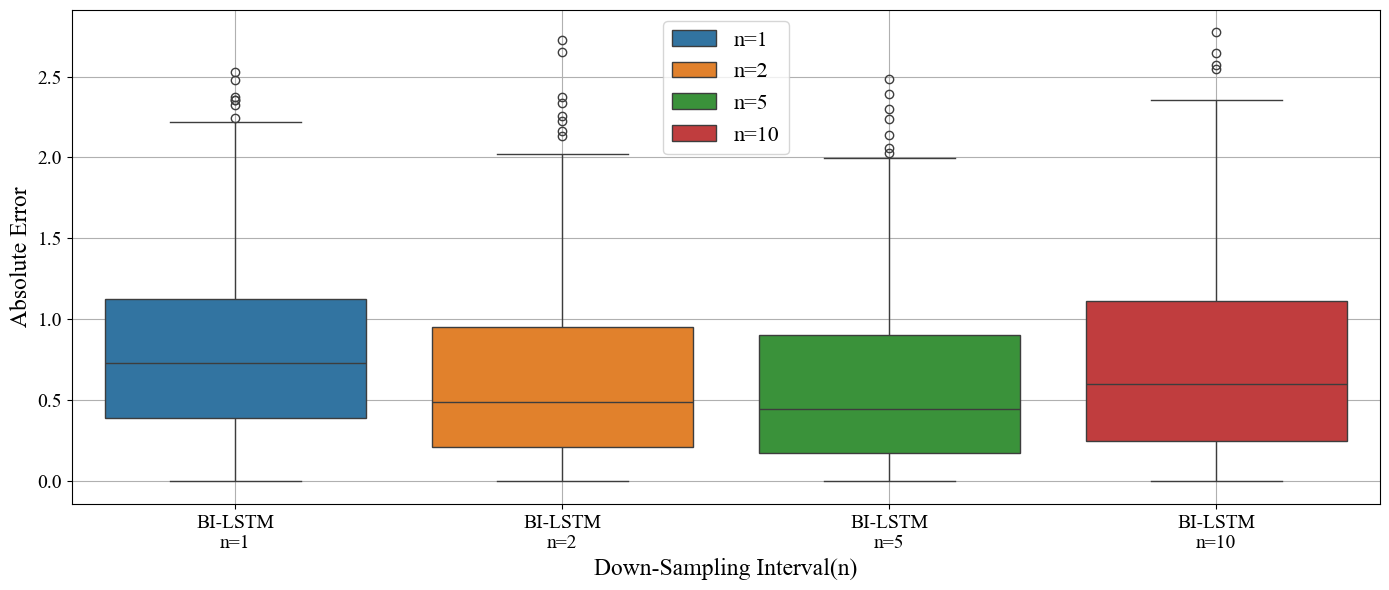

📊 Peak Error Summary (per model & sampling interval)
  model  n  count   mean     Q1  median     Q3
BI-LSTM  1    341 0.8239 0.3891  0.7308 1.1256
BI-LSTM  2    339 0.6604 0.2158  0.4920 0.9557
BI-LSTM  5    339 0.6186 0.1776  0.4481 0.9063
BI-LSTM 10    339 0.7491 0.2498  0.6021 1.1167

✅ Summary saved to '../peak_dataset/6DoF26DoF/peak_error_summary.csv'


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# ✅ Dataset path configuration
# ------------------------------
DATA_PATH = "../peak_dataset/6DoF26DoF/matched_peak_points_bilstm_predlen200.csv"
SUMMARY_OUTPUT_PATH = "../peak_dataset/6DoF26DoF/peak_error_summary.csv"

# ------------------------------
# ✅ Histogram bin configuration
# ------------------------------
HIST_BINS = np.linspace(0, 1.0, 21)
BIN_WIDTH = 0.05

# ------------------------------
# 1. Load matched peak/trough dataset
# ------------------------------
df = pd.read_csv(DATA_PATH)

# Treat both peaks and troughs as peaks
df_peaks = df.copy()
df_peaks = df_peaks.dropna(subset=["gt_value", "pred_value"])

# ------------------------------
# 2. Compute absolute error and group by model/sample interval
# ------------------------------
df_peaks["error"] = np.abs(df_peaks["gt_value"] - df_peaks["pred_value"])
sample_intervals = sorted(df_peaks["n"].unique())
models = sorted(df_peaks["model"].unique())

error_by_n_model = {
    n: {
        model.upper(): df_peaks[(df_peaks["n"] == n) & (df_peaks["model"] == model)]["error"].values
        for model in models
    }
    for n in sample_intervals
}

# ------------------------------
# 3. Plot histogram for each n (multi-model)
# ------------------------------
def plot_combined_error_histogram(error_dict, title_prefix="Peak Prediction Absolute Error Ratio"):
    model_colors = {
        "GRU": "blue",
        "LSTM": "orange",
        "RNN": "green",
        "BI-LSTM": "gray"
    }

    for n, model_errors in error_dict.items():
        plt.figure(figsize=(10, 5))
        for name, errors in model_errors.items():
            if len(errors) == 0:
                continue
            counts, _ = np.histogram(errors, bins=HIST_BINS)
            freqs = counts / counts.sum()
            bin_centers = 0.5 * (HIST_BINS[:-1] + HIST_BINS[1:])
            plt.bar(bin_centers, freqs, width=BIN_WIDTH, alpha=0.5,
                    label=name, edgecolor="black", color=model_colors.get(name.upper(), "gray"))
        plt.xlabel("Absolute Error Range")
        plt.ylabel("Ratio")
        plt.title(f"{title_prefix} (n={n})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ------------------------------
# 4. Plot histogram for each model (multi-n)
# ------------------------------
def plot_error_histogram_by_model(error_dict, sample_intervals, title_prefix="Model-wise Peak Absolute Error Ratio"):
    n_color_map = {1: "tab:blue", 2: "tab:orange", 5: "tab:green", 10: "tab:red"}
    model_names = sorted({m for d in error_dict.values() for m in d})

    for model in model_names:
        plt.figure(figsize=(10, 5))
        for n in sample_intervals:
            errors = error_dict[n].get(model, [])
            if len(errors) == 0:
                continue
            counts, _ = np.histogram(errors, bins=HIST_BINS)
            freqs = counts / counts.sum()
            bin_centers = 0.5 * (HIST_BINS[:-1] + HIST_BINS[1:])
            plt.bar(bin_centers, freqs, width=BIN_WIDTH, alpha=0.6,
                    label=f"n={n}", color=n_color_map.get(n, "gray"), edgecolor="black")
        plt.xlabel("Absolute Error Range")
        plt.ylabel("Ratio")
        plt.title(f"{title_prefix} — {model}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ------------------------------
# 5. Boxplot for each model
# ------------------------------
def plot_boxplot_by_model(error_dict, sample_intervals, title_prefix="Model-wise Peak Absolute Error BoxPlot"):
    n_color_map = {1: "tab:blue", 2: "tab:orange", 5: "tab:green", 10: "tab:red"}
    model_names = sorted({m for d in error_dict.values() for m in d})

    for model in model_names:
        records = [
            {"n": f"n={n}", "error": e}
            for n in sample_intervals
            for e in error_dict[n].get(model, [])
        ]
        if not records:
            continue
        df_box = pd.DataFrame(records)
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=df_box, x="n", y="error",
                    palette=[n_color_map.get(int(n.split("=")[1]), "gray") for n in df_box["n"].unique()])
        plt.title(f"{title_prefix} — {model}")
        plt.xlabel("Sample Interval")
        plt.ylabel("Absolute Error")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ------------------------------
# 6. Combined boxplot (all models)
# ------------------------------
def plot_combined_boxplot(error_dict, sample_intervals, title="All Models — Peak Absolute Error BoxPlot"):
    n_color_map = {1: "tab:blue", 2: "tab:orange", 5: "tab:green", 10: "tab:red"}

    records = [
        {
            "Model": model,
            "n": n,
            "Model-n": f"{model}\nn={n}",
            "error": e
        }
        for n in sample_intervals
        for model, errors in error_dict[n].items()
        for e in errors
    ]
    if not records:
        print("⚠️ No data available for combined boxplot.")
        return

    df_box = pd.DataFrame(records)
    model_n_order = sorted(df_box[["Model", "n"]].drop_duplicates().values.tolist(), key=lambda x: (x[0], x[1]))
    model_n_labels = [f"{m}\nn={n}" for m, n in model_n_order]
    df_box["Model-n"] = pd.Categorical(df_box["Model-n"], categories=model_n_labels, ordered=True)
    df_box["n_str"] = df_box["n"].apply(lambda x: f"n={x}")

    palette_dict = {f"n={n}": n_color_map.get(n, "gray") for n in sample_intervals}

    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df_box, x="Model-n", y="error", hue="n_str", palette=palette_dict)
    fontsize = 17
    plt.xlabel("Down-Sampling Interval(n)", fontsize=fontsize)
    plt.ylabel("Absolute Error", fontsize=fontsize)
    plt.xticks(fontsize=fontsize - 3)
    plt.yticks(fontsize=fontsize - 3)
    plt.legend(fontsize=fontsize - 1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------
# 7. Print summary statistics
# ------------------------------
def print_peak_error_summary(error_dict, save_path=SUMMARY_OUTPUT_PATH):
    print("📊 Peak Error Summary (per model & sampling interval)")
    print("=" * 90)

    records = []
    for n, model_errors in error_dict.items():
        for model, errors in model_errors.items():
            errors = np.array(errors)
            count = len(errors)
            mean_error = np.mean(errors) if count else 0
            median_error = np.median(errors) if count else 0
            q1 = np.percentile(errors, 25) if count else 0
            q3 = np.percentile(errors, 75) if count else 0
            records.append({
                "model": model,
                "n": n,
                "count": count,
                "mean": mean_error,
                "Q1": q1,
                "median": median_error,
                "Q3": q3
            })

    df_summary = pd.DataFrame(records).sort_values(by=["model", "n"])
    df_summary[["mean", "median", "Q1", "Q3"]] = df_summary[["mean", "median", "Q1", "Q3"]].round(4)

    print(df_summary.to_string(index=False))
    df_summary.to_csv(save_path, index=False)
    print(f"\n✅ Summary saved to '{save_path}'")

# ------------------------------
# 8. Execute main visualizations and summary
# ------------------------------
plot_combined_boxplot(error_by_n_model, sample_intervals)
print_peak_error_summary(error_by_n_model)


### Peak OverEstimate Ratio

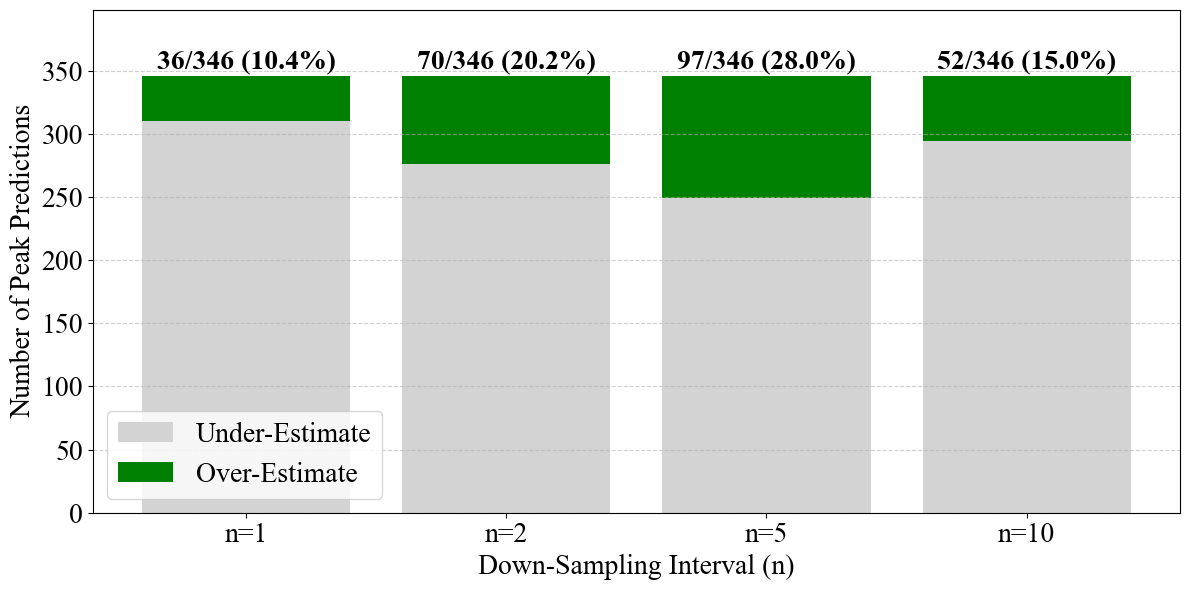

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Settings
# -----------------------------
selected_pred_len = 200
target_model = "bi-lstm"

# -----------------------------
# Load Data
# -----------------------------
df = pd.read_csv("../peak_dataset/6DoF26DoF/matched_peak_points_bilstm_predlen200.csv")
df = df[df["pred_len"] == selected_pred_len]
df = df[df["model"].str.lower() == target_model]

sample_intervals = sorted(df["n"].unique())

# -----------------------------
# Overestimation Analysis
# -----------------------------
def analyze_overestimate(df, n):
    subset = df[df["n"] == n]
    peaks = subset[subset["is_peak"] == True]
    troughs = subset[subset["is_peak"] == False]

    peak_over = (peaks["pred_value"] > peaks["gt_value"]).sum()
    trough_over = (troughs["pred_value"] < troughs["gt_value"]).sum()

    total = len(peaks) + len(troughs)
    over = peak_over + trough_over
    under = total - over
    return over, under, total

# -----------------------------
# Visualization: Bar Plot
# -----------------------------
over_list, under_list, total_list = [], [], []

for n in sample_intervals:
    over, under, total = analyze_overestimate(df, n)
    over_list.append(over)
    under_list.append(under)
    total_list.append(total)

x = np.arange(len(sample_intervals))
bar_width = 0.6

plt.figure(figsize=(12, 6))
plt.bar(x, under_list, color="lightgray", label="Under-Estimate")
plt.bar(x, over_list, bottom=under_list, color="green", label="Over-Estimate")

fontsize = 20
for i in range(len(x)):
    ratio = over_list[i] / total_list[i] * 100 if total_list[i] > 0 else 0.0
    plt.text(x[i], under_list[i] + over_list[i] + 5,
             f"{over_list[i]}/{total_list[i]} ({ratio:.1f}%)",
             ha="center", fontsize=fontsize, fontweight="bold")

plt.xticks(x, [f"n={n}" for n in sample_intervals], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel("Down-Sampling Interval (n)", fontsize=fontsize)
plt.ylabel("Number of Peak Predictions", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.ylim(0, max(total_list) * 1.15 if total_list else 10)
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### Peak Curvature

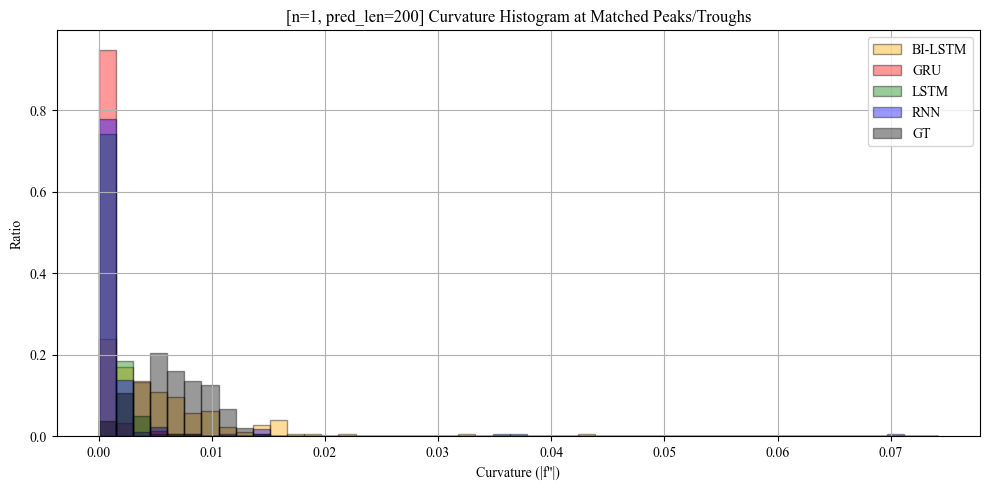

C:\Users\haeun\AppData\Local\Temp\ipykernel_27588\26352202.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_curvature, x="Model", y="Curvature", palette=palette_filtered)


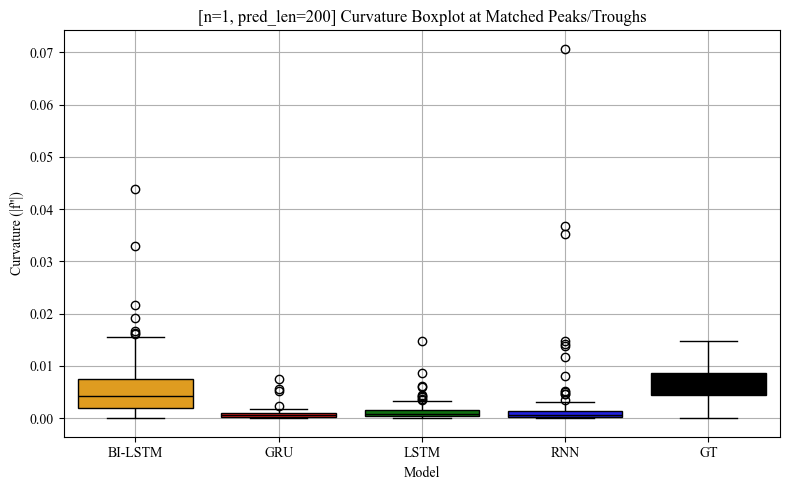

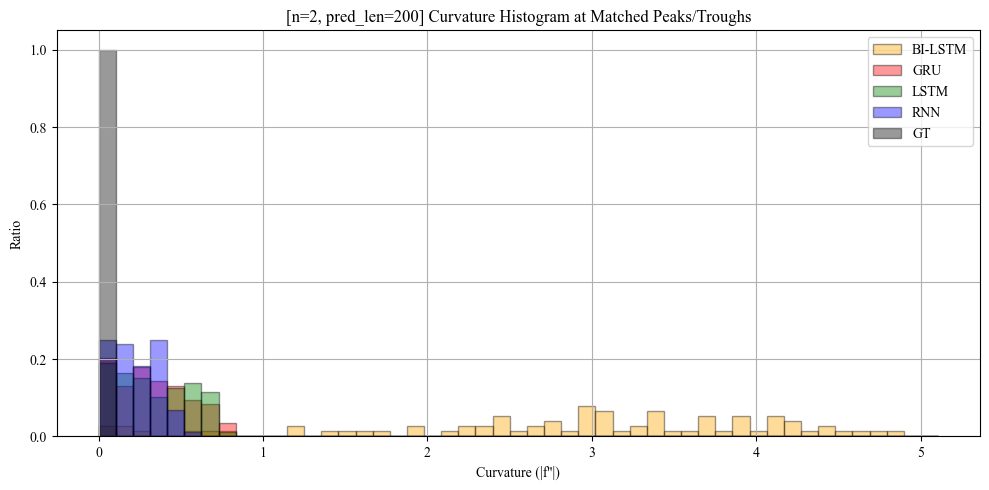

C:\Users\haeun\AppData\Local\Temp\ipykernel_27588\26352202.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_curvature, x="Model", y="Curvature", palette=palette_filtered)


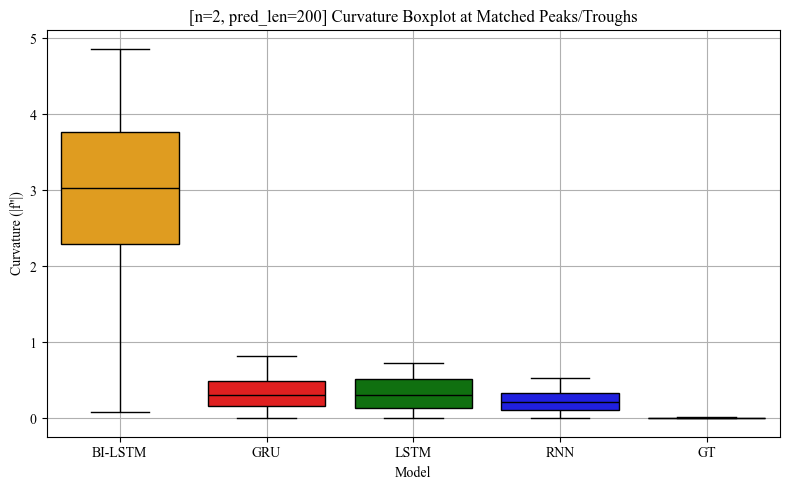

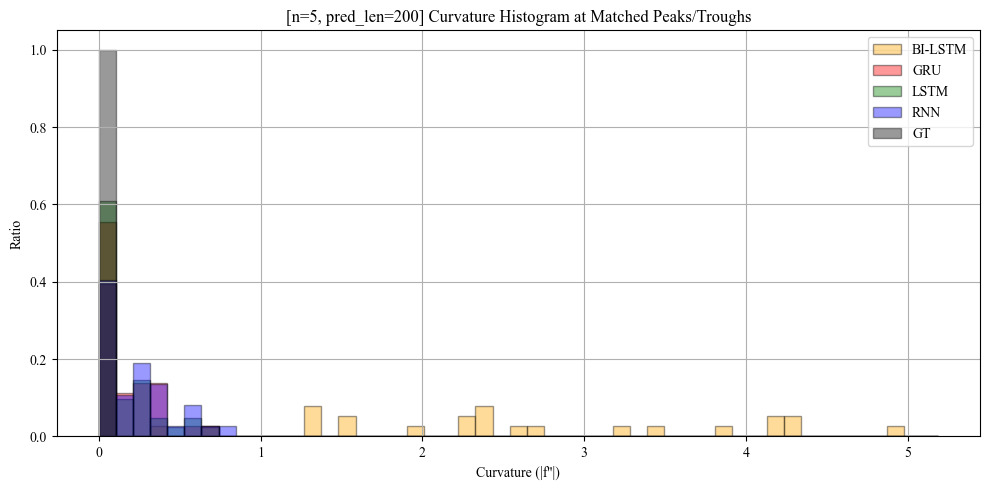

C:\Users\haeun\AppData\Local\Temp\ipykernel_27588\26352202.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_curvature, x="Model", y="Curvature", palette=palette_filtered)


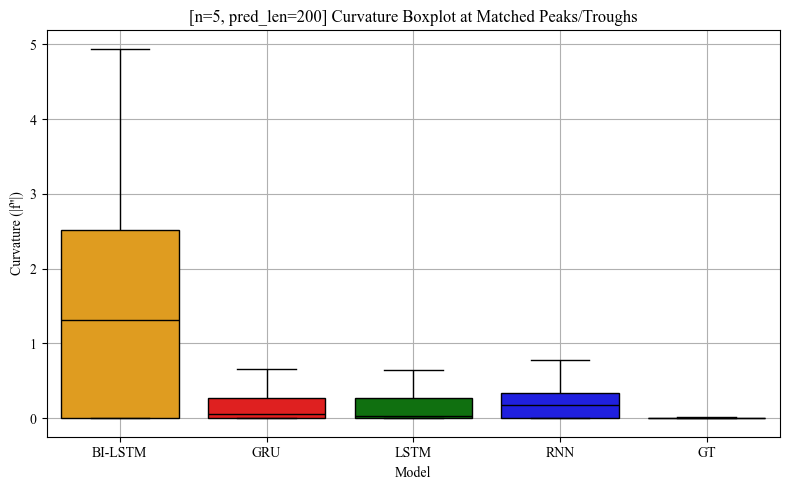

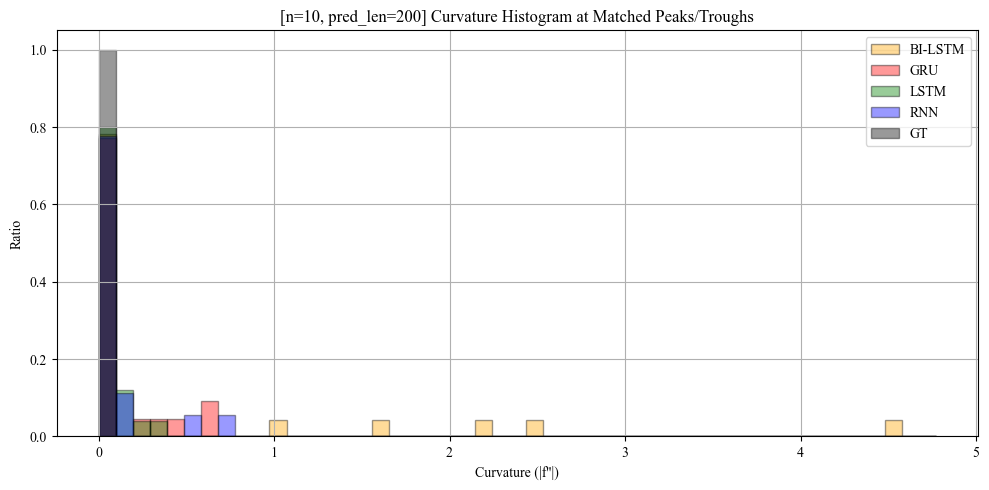

C:\Users\haeun\AppData\Local\Temp\ipykernel_27588\26352202.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_curvature, x="Model", y="Curvature", palette=palette_filtered)


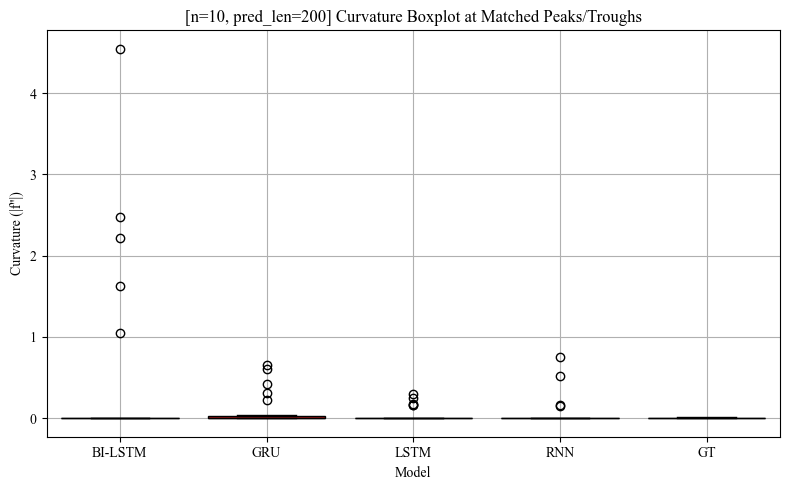

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks

# ------------------------------
# Configuration
# ------------------------------
DISTANCE = 50  # Minimum distance between peaks
BIN_COUNT = 50  # Number of bins for histogram
MIN_PRED_GAP = 55  # Minimum gap between predictions
RANGE_DIST = 50  # Matching range for prediction and GT
SELECTED_PRED_LEN = 200  # Fixed prediction length
SAMPLE_INTERVALS = [1, 2, 5, 10]  # Downsampling intervals

# Color map for different models
MODEL_COLORS = {
    "GRU": "red",
    "LSTM": "green",
    "RNN": "blue",
    "BI-LSTM": "orange",
    "GT": "black"
}

# ------------------------------
# Load prediction results
# ------------------------------
df = pd.read_csv("../peak_dataset/6DoF26DoF/seq200_downsampling_predictions_sorted.csv")

# ------------------------------
# Load ground truth (GT)
# ------------------------------
gt_df = pd.read_csv("../downsampled_data/Downsampling1/test_n1.csv")
gt_df = gt_df[gt_df["file_index"] == 4].reset_index(drop=True)
gt_signal = gt_df["x3(m)"].values.astype(np.float32)
gt = np.array(gt_signal)
gt_x = np.arange(len(gt))

# ------------------------------
# Detect GT peaks and troughs
# ------------------------------
gt_peaks, _ = find_peaks(gt, distance=DISTANCE)
gt_troughs, _ = find_peaks(-gt, distance=DISTANCE)
gt_peaks = [i for i in gt_peaks if i % 100 not in [0, 1]]
gt_troughs = [i for i in gt_troughs if i % 100 not in [0, 1]]

# ------------------------------
# Organize predictions by model and sampling interval
# ------------------------------
models = df["model"].unique()
base_models = [m.upper() for m in models]
prediction_by_n = {n: {} for n in SAMPLE_INTERVALS}
timestep_by_n = {n: {} for n in SAMPLE_INTERVALS}
for model in models:
    for n in SAMPLE_INTERVALS:
        subset = df[(df["model"] == model) & (df["n"] == n)]
        prediction_by_n[n][model.upper()] = subset["prediction"].values
        timestep_by_n[n][model.upper()] = subset["timestep"].values

# ------------------------------
# Curvature calculation
# ------------------------------
def compute_curvature(signal, indices):
    return np.array([
        abs(signal[i + 1] - 2 * signal[i] + signal[i - 1])
        for i in indices if 0 < i < len(signal) - 1
    ])

# ------------------------------
# Match predicted extrema with GT extrema under constraints
# ------------------------------
def match_extrema_with_gap(gt_indices, pred_indices, gt_vals, pred_vals, range_dist=50, is_peak=True, min_pred_gap=15):
    matched_pred = set()
    matched_gt = []
    last_pred_x = -np.inf
    pred_indices = sorted(pred_indices)

    for gt_idx in gt_indices:
        candidates = [
            p for p in pred_indices
            if abs(p - gt_idx) <= range_dist
            and p not in matched_pred
            and abs(p - last_pred_x) >= min_pred_gap
        ]
        if not candidates:
            continue

        filtered_candidates = []
        for i, p in enumerate(candidates):
            current_val = pred_vals[p]
            try:
                next_p = pred_indices[pred_indices.index(p) + 1]
                next_val = pred_vals[next_p]
                if is_peak:
                    if next_val <= current_val:
                        filtered_candidates.append(p)
                else:
                    if next_val >= current_val:
                        filtered_candidates.append(p)
            except (IndexError, ValueError):
                filtered_candidates.append(p)

        if not filtered_candidates:
            continue

        best_pred = (
            max(filtered_candidates, key=lambda i: pred_vals[i])
            if is_peak else
            min(filtered_candidates, key=lambda i: pred_vals[i])
        )
        matched_pred.add(best_pred)
        matched_gt.append(gt_idx)
        last_pred_x = best_pred

    return matched_gt

# ------------------------------
# Analyze and visualize for each sampling interval
# ------------------------------
for n in SAMPLE_INTERVALS:
    records = []
    global_max_curv = 0

    for name in base_models:
        values = np.array(prediction_by_n[n][name])
        pred_timestep = np.array(timestep_by_n[n][name], dtype=int)
        pred_peaks, _ = find_peaks(values, distance=DISTANCE)
        pred_troughs, _ = find_peaks(-values, distance=DISTANCE)

        pred_peak_x = [pred_timestep[i] for i in pred_peaks if pred_timestep[i] % 100 not in [0, 1]]
        pred_trough_x = [pred_timestep[i] for i in pred_troughs if pred_timestep[i] % 100 not in [0, 1]]

        max_idx = len(gt)
        pred_aligned = np.zeros_like(gt)
        for i, t in enumerate(pred_timestep):
            if t < max_idx:
                pred_aligned[t] = values[i]

        matched_peaks = match_extrema_with_gap(gt_peaks, pred_peak_x, gt, pred_aligned, RANGE_DIST, True, MIN_PRED_GAP)
        matched_troughs = match_extrema_with_gap(gt_troughs, pred_trough_x, gt, pred_aligned, RANGE_DIST, False, MIN_PRED_GAP)
        matched_extrema = matched_peaks + matched_troughs

        curvs = compute_curvature(pred_aligned, matched_extrema)
        records.extend([{"Model": name, "Curvature": c} for c in curvs])
        if len(curvs) > 0:
            global_max_curv = max(global_max_curv, np.max(curvs))

    # GT curvature
    gt_extrema = [i for i in (gt_peaks + gt_troughs) if 0 < i < len(gt) - 1]
    gt_curvs = compute_curvature(gt, gt_extrema)
    records.extend([{"Model": "GT", "Curvature": c} for c in gt_curvs])
    if len(gt_curvs) > 0:
        global_max_curv = max(global_max_curv, np.max(gt_curvs))

    df_curvature = pd.DataFrame(records)

    # ✅ Histogram
    plt.figure(figsize=(10, 5))
    bins = np.linspace(0, global_max_curv * 1.05, BIN_COUNT)
    bin_width = bins[1] - bins[0]

    for model_name in df_curvature["Model"].unique():
        curvs = df_curvature[df_curvature["Model"] == model_name]["Curvature"].values
        if len(curvs) == 0:
            continue
        counts, _ = np.histogram(curvs, bins=bins)
        ratios = counts / np.sum(counts)
        centers = 0.5 * (bins[:-1] + bins[1:])
        plt.bar(centers, ratios, width=bin_width,
                alpha=0.4, label=model_name,
                color=MODEL_COLORS.get(model_name, None), edgecolor='black')

    plt.title(f"[n={n}, pred_len={SELECTED_PRED_LEN}] Curvature Histogram at Matched Peaks/Troughs")
    plt.xlabel("Curvature (|f''|)")
    plt.ylabel("Ratio")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ✅ Boxplot
    plt.figure(figsize=(8, 5))
    palette_filtered = {k: v for k, v in MODEL_COLORS.items() if k in df_curvature["Model"].unique()}
    sns.boxplot(data=df_curvature, x="Model", y="Curvature", palette=palette_filtered)
    plt.title(f"[n={n}, pred_len={SELECTED_PRED_LEN}] Curvature Boxplot at Matched Peaks/Troughs")
    plt.xlabel("Model")
    plt.ylabel("Curvature (|f''|)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
